## Training advanced models 

In [ ]:
import pandas as pd
import numpy as np

# advanced models 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# metrics 
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc

# visualisation 
import matplotlib.pyplot as plt 
import seaborn as sns 

sns.set(style='whitegrid')

In [4]:
# laod the data 


from pathlib import Path

DATA_DIR = Path('../data/processed/')

# SMOTE balanced training set
X_train = pd.read_parquet(DATA_DIR / 'X_train_balanced_smote.parquet')
y_train = pd.read_parquet(DATA_DIR / 'y_train_balanced_smote.parquet').squeeze()

# Scaled validation set
X_val = pd.read_parquet(DATA_DIR / 'X_val.parquet')
y_val = pd.read_parquet(DATA_DIR / 'y_val.parquet').squeeze()


In [5]:
# define the helper function 

def evaluate_model(model, X_val, y_val):
  y_pred = model.predict(X_val)
  y_proba = model.predict_proba(X_val)[:, 1]

  roc = roc_auc_score(y_val, y_proba)
  precision, recall, _ = precision_recall_curve(y_val, y_proba)
  pr_auc = auc(recall, precision)

  return {
    "roc_auc": roc,
    "pr_auc": pr_auc,
    "precision": precision,
    "recall": recall,
    "y_pred": y_pred
  }


### XGBoost

In [7]:
xgb = XGBClassifier(
  n_estimators=200,
  max_depth=6, 
  scale_pos_weight=int((len(y_train)-sum(y_train)) / sum(y_train)),
  random_state=42,
  use_label_encoder=False,
  eval_metric='logloss'
)

xgb.fit(X_train, y_train)

/Users/rajendran/Desktop/real_time_fraud_detection_system_for_financial_transactions/real-time-fraud-detection-system-for-financial-transactions/.venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [17:54:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [8]:
print("XGBoost on validation set")

xgb_metric = evaluate_model(xgb, X_val, y_val)
xgb_metric

XGBoost on validation set


{'roc_auc': 0.9794320312762407,
 'pr_auc': 0.8291008643533992,
 'precision': array([0.00173217, 0.00173221, 0.00173225, ..., 1.        , 1.        ,
        1.        ]),
 'recall': array([1.        , 1.        , 1.        , ..., 0.08108108, 0.01351351,
        0.        ]),
 'y_pred': array([0, 0, 0, ..., 0, 0, 0])}

### LightGBM

In [9]:
lgbm = LGBMClassifier(
  n_estimators=200,
  max_depth=6,
  class_weight='balanced',
  random_state=42
)

lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 199020, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 398040, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,6
,learning_rate,0.1
,n_estimators,200
,subsample_for_bin,200000
,objective,None
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [10]:
print("LightGBM on validation set")

lgbm_metric = evaluate_model(lgbm, X_val, y_val)
lgbm_metric

LightGBM on validation set


{'roc_auc': 0.9355589791493841,
 'pr_auc': 0.778844372743381,
 'precision': array([0.00173217, 0.00173221, 0.00173225, ..., 1.        , 1.        ,
        1.        ]),
 'recall': array([1.        , 1.        , 1.        , ..., 0.02702703, 0.01351351,
        0.        ]),
 'y_pred': array([0, 0, 0, ..., 0, 0, 0])}

### CatBoost

In [11]:
cat = CatBoostClassifier(
  iterations=200,
  depth=6,
  learning_rate=0.1,
  loss_function='Logloss',
  class_weights=[1, (len(y_train)-sum(y_train)) / sum(y_train)],
  verbose=0,
  random_seed=42
)

cat.fit(X_train, y_train)

In [12]:
print("CatBoost on validation set")

cat_metric = evaluate_model(cat, X_val, y_val)
cat_metric

CatBoost on validation set


{'roc_auc': 0.9753764245639407,
 'pr_auc': 0.8148128836842473,
 'precision': array([0.00173217, 0.00173221, 0.00173225, ..., 1.        , 1.        ,
        1.        ]),
 'recall': array([1.        , 1.        , 1.        , ..., 0.04054054, 0.01351351,
        0.        ]),
 'y_pred': array([0, 0, 0, ..., 0, 0, 0])}

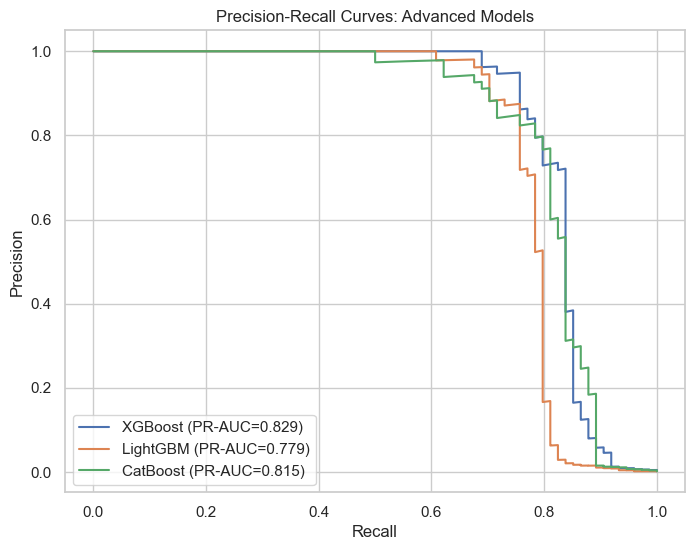

,Model,ROC-AUC,PR-AUC
0,XGBoost,0.979432,0.829101
2,CatBoost,0.975376,0.814813
1,LightGBM,0.935559,0.778844


In [ ]:
plt.figure(figsize=(8,6))
plt.plot(xgb_metric['recall'], xgb_metric['precision'], label=f"XGBoost (PR-AUC={xgb_metric['pr_auc']:.3f})")
plt.plot(lgbm_metric['recall'], lgbm_metric['precision'], label=f"LightGBM (PR-AUC={lgbm_metric['pr_auc']:.3f})")
plt.plot(cat_metric['recall'], cat_metric['precision'], label=f"CatBoost (PR-AUC={cat_metric['pr_auc']:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves: Advanced Models")
plt.legend()
save_path = "../reports/figures/13_precision_recall_curve_advanced_models.png"  
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

# Summary Table
results_df = pd.DataFrame([
    {"Model": "XGBoost", "ROC-AUC": xgb_metric['roc_auc'], "PR-AUC": xgb_metric['pr_auc']},
    {"Model": "LightGBM", "ROC-AUC": lgbm_metric['roc_auc'], "PR-AUC": lgbm_metric['pr_auc']},
    {"Model": "CatBoost", "ROC-AUC": cat_metric['roc_auc'], "PR-AUC": cat_metric['pr_auc']}
]).sort_values(by="PR-AUC", ascending=False)

results_df


In [17]:
import joblib
joblib.dump(xgb, "../models/xgboost_model.joblib")

['../models/xgboost_model.joblib']